<a href="https://colab.research.google.com/github/Michwynn/London-Airbnb-Analysis---2/blob/Michael/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
# set up working directory
import os
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Airbnb_Milestone2

# data manipulation
import pandas as pd
import numpy as np 
from tqdm import tqdm

# nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # comment out if already downloaded
stop_words = set(stopwords.words('english'))

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, fbeta_score, jaccard_score, log_loss, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV

# Plot ROC AUC Curve & Visualisation
!pip install yellowbrick
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, PrecisionRecallCurve

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
%matplotlib inline



# supress warnings
import warnings 
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1wUOfFY-ki2nFzneeaTtXLEeMjaSdKrrj/Airbnb_Milestone2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Configuration**

In [118]:
%%time

RANDOM_SEED = 42
fractions = np.array([0.8, 0.1, 0.1])
cleaned_df = pd.read_csv('Datasets/cleaned_df.csv', lineterminator = '\n') # reading the datasest

# Data pre-processing using conventional method (ok accuracy / fast speed)
def clean_text(comments):
  punc = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â"""
  punc_removed = [char for char in comments if char not in punc]
  punc_join = ''.join(punc_removed)
  cleaned = []
  splitted = punc_join.split()
  for x in splitted:
    if x.isalpha() and x not in stop_words:
      cleaned.append(x.lower())
  result = ' '.join(cleaned)
  return result

cleaned_df['cleaned_comments'] = cleaned_df['comments'].apply(clean_text)

# TfidfVectorizer:
min_df = 25

# Logistic Regression:
solver = 'lbfgs'
multi_class = 'auto'

# RF & Adaboost:
n_estimators = 10
max_depth = 3

# K Nearest Neighbour:
k = 3

CPU times: user 57.8 s, sys: 2.74 s, total: 1min
Wall time: 1min 24s


**Downsampling method for imbalance dataset**

In [119]:
cleaned_df['sentiment'].value_counts()

Positive    1045528
Neutral       25786
Negative      16185
Name: sentiment, dtype: int64

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

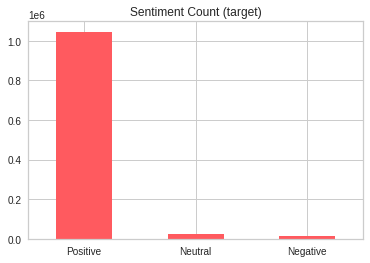

In [120]:
cleaned_df['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title = 'Sentiment Count (target)')
plt.xticks(rotation=0)

class_positive: (1045528, 14)
class_neutral: (25786, 14)
class_negative: (16185, 14)
Random Under Sampling leads to.........


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

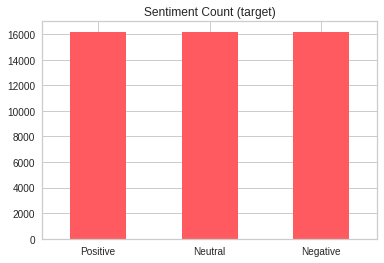

In [121]:
# class count
class_count_positive, class_count_neutral, class_count_negative = cleaned_df['sentiment'].value_counts()


# Separate sentiment into each df
class_positive = cleaned_df[cleaned_df['sentiment'] == "Positive"]
class_neutral = cleaned_df[cleaned_df['sentiment'] == "Neutral"]
class_negative = cleaned_df[cleaned_df['sentiment'] == "Negative"]

print('class_positive:', class_positive.shape)
print('class_neutral:', class_neutral.shape)
print('class_negative:', class_negative.shape)
print("Random Under Sampling leads to.........")
      
# As negative sentiment is the lowest case count, we will do random undersampling for both positive and neutral sentiments to get an equally distributed and balanced dataset
class_positive_under = class_positive.sample(class_count_negative, random_state = RANDOM_SEED)
class_neutral_under = class_neutral.sample(class_count_negative, random_state = RANDOM_SEED)

# Combine all dataframes
cleaned_df_undersampling = pd.concat([class_positive_under, class_neutral_under, class_negative], axis = 0)
cleaned_df_undersampling['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title ='Sentiment Count (target)')
plt.xticks(rotation=0)

In [122]:
#cleaned_df_undersampling.to_csv('cleaned_df_undersampling.csv')

**Split datasets into train, validation and test sets**

We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively.

In [123]:
def get_train_val_test(df, fractions, RANDOM_SEED):

  # Get the required input and target variables from dataframe and drop NA rows:
  df = df[['cleaned_comments','sentiment']].dropna()
  # shuffling the data:
  df = df.sample(frac = 1, random_state = RANDOM_SEED)
  # split into training, validation and testing sets
  train_df, val_df, test_df = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))

  if len(train_df) + len(val_df) + len(test_df) != len(df):
    print("Check the splitting method!")
  else:
    return train_df, val_df, test_df

**Splitting...**

In [124]:
train_df, val_df, test_df = get_train_val_test(cleaned_df_undersampling, fractions, RANDOM_SEED)

**Convert text data to features - TF-IDF and get target input**

In [125]:
%%time
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = min_df, norm ='l2')
X_train = vectorizer.fit_transform(train_df.cleaned_comments)
y_train = list(train_df.sentiment)

CPU times: user 3.13 s, sys: 185 ms, total: 3.31 s
Wall time: 3.72 s


**Fit the classifier on the data**

In [126]:
%%time
clf_log = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)
clf_log.fit(X_train, y_train)

CPU times: user 2.91 s, sys: 32.9 ms, total: 2.95 s
Wall time: 2.96 s


LogisticRegression(random_state=42)

**Generate validation data**

In [127]:
%%time
X_val = vectorizer.transform(val_df.cleaned_comments)
y_val = list(val_df.sentiment)

CPU times: user 148 ms, sys: 1.97 ms, total: 150 ms
Wall time: 152 ms


**Generate logistic regression (baseline model) prediction**

Logistic regression is a good model because it trains quickly even on large datasets and provides very robust results. Other good model choices include SVMs, Random Forests, and Naive Bayes.

In [128]:
%%time
lr_pred = clf_log.predict(X_val)
lr_f1 = f1_score(y_val, lr_pred, average = 'macro')
print("F1 score for baseline regression:", lr_f1)

F1 score for baseline regression: 0.9173549143464004
CPU times: user 24.5 ms, sys: 0 ns, total: 24.5 ms
Wall time: 30 ms


**Comparing all classification models**

In [129]:
clf_log = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)
clf_svm = svm.SVC(decision_function_shape = 'ovr', probability = True, random_state = RANDOM_SEED)
clf_svm_ = svm.SVC(decision_function_shape = 'ovr', random_state = RANDOM_SEED) # without probability = True
clf_nb = MultinomialNB()
clf_dt = tree.DecisionTreeClassifier(random_state = RANDOM_SEED)
clf_rf = RandomForestClassifier(random_state = RANDOM_SEED)
clf_gbc = GradientBoostingClassifier(random_state = RANDOM_SEED)
clf_boost = AdaBoostClassifier(random_state = RANDOM_SEED)
clf_xtratree = ExtraTreesClassifier(random_state = RANDOM_SEED)
clf_knn = KNeighborsClassifier(n_neighbors = 5) # default = 5

model_names = ["LogisticRegression (Base)", "SupportVectorMachine", "MultinomialNB", "DecisionTreeClassifier", 
               "RandomForestClassifier", "GradientBoostingClassifier", "AdaBoostClassifier", "ExtraTreesClassifier", "KNeighborsClassifier"]

model_list = [clf_log, clf_svm, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]
model_list_ = [clf_log, clf_svm_, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]

In [14]:
accuracy = []
precision = []
recall = []
f1score = []
jaccard = []
fbeta = []
roc_auc = []
logloss_ = []

for model in tqdm(model_list):
  model.fit(X_train, y_train)
  model_predict = model.predict(X_val)
  accuracy.append(accuracy_score(model_predict, y_val))
  precision.append(precision_score(model_predict, y_val, average = 'macro'))
  recall.append(recall_score(model_predict, y_val, average = 'macro'))
  f1score.append(f1_score(model_predict, y_val, average = 'macro'))
  jaccard.append(jaccard_score(model_predict, y_val, average = 'macro'))
  fbeta.append(fbeta_score(model_predict, y_val, average = 'macro', beta = 0.5))
  roc_auc.append(roc_auc_score(y_val, model.predict_proba(X_val), multi_class = 'ovr', average = 'macro'))
  logloss_.append(log_loss(y_val, model.predict_proba(X_val)))

100%|██████████| 9/9 [36:09<00:00, 241.06s/it]


In [15]:
pd.DataFrame(list(zip(model_names, accuracy, precision, recall, f1score, jaccard, fbeta, roc_auc, logloss_)),
               columns =['Classifier', 'Accuracy (Balanced)', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)', 'Jaccard Score (Macro)', 'F-beta Score (Macro)', 'AUC ROC Score', 'Log Loss'])

,Classifier,Accuracy (Balanced),Precision (Macro),Recall (Macro),F1 Score (Macro),Jaccard Score (Macro),F-beta Score (Macro),AUC ROC Score,Log Loss
0,LogisticRegression (Base),0.917405,0.917423,0.917317,0.917355,0.848002,0.917392,0.978716,0.275187
1,SupportVectorMachine,0.918023,0.918027,0.918937,0.918316,0.849698,0.918102,0.978504,0.264870
2,MultinomialNB,0.805973,0.804541,0.837003,0.800854,0.669427,0.799297,0.965882,0.464833
3,DecisionTreeClassifier,0.844902,0.845106,0.844760,0.844843,0.735042,0.844980,0.872303,5.192471
4,RandomForestClassifier,0.897425,0.897350,0.898024,0.897460,0.815336,0.897339,0.971416,0.356477
5,GradientBoostingClassifier,0.877240,0.877357,0.876875,0.876360,0.781339,0.876778,0.965765,0.409064
6,AdaBoostClassifier,0.845726,0.845793,0.847777,0.842631,0.731398,0.843556,0.861810,1.019145
7,ExtraTreesClassifier,0.904840,0.904783,0.905709,0.905083,0.827693,0.904864,0.972824,0.379646
8,KNeighborsClassifier,0.405973,0.409181,0.671700,0.311807,0.197708,0.339615,0.506460,16.701965


## **Attempt to improve KNN model**

**Plotting Error Rate to find the best K-value**

In [130]:
error_rate = []
for i in tqdm(range(1,40)):
 knn = KNeighborsClassifier(n_neighbors = i)
 knn.fit(X_train, y_train)
 pred_i = knn.predict(X_val)
 error_rate.append(np.mean(pred_i != y_val))

100%|██████████| 39/39 [04:30<00:00,  6.95s/it]


Minimum Error:- 0.5680741503604532 at K = 0


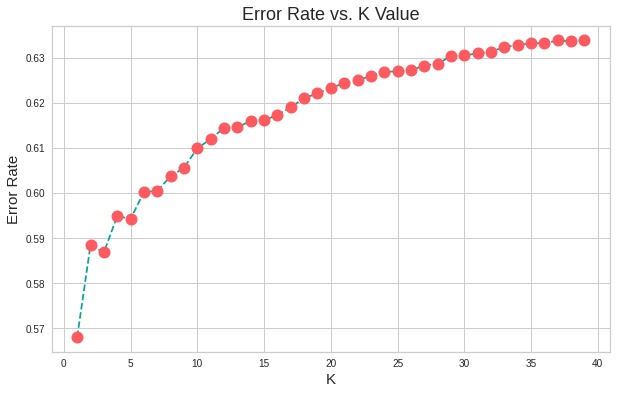

In [131]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color = '#00A699', linestyle = 'dashed', 
         marker = 'o', markerfacecolor = '#FF5A5F', markersize = 12)
plt.title('Error Rate vs. K Value', fontsize = 18)
plt.xlabel('K', fontsize = 15)
plt.ylabel('Error Rate', fontsize = 15)
print("Minimum Error:-", min(error_rate),"at K =", error_rate.index(min(error_rate)))

In [132]:
acc = []
for i in tqdm(range(1,40)):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    y_predict = neigh.predict(X_val)
    acc.append(metrics.accuracy_score(y_val, y_predict))

100%|██████████| 39/39 [04:08<00:00,  6.38s/it]


Maximum Accuracy:- 0.43192584963954683 at K = 0


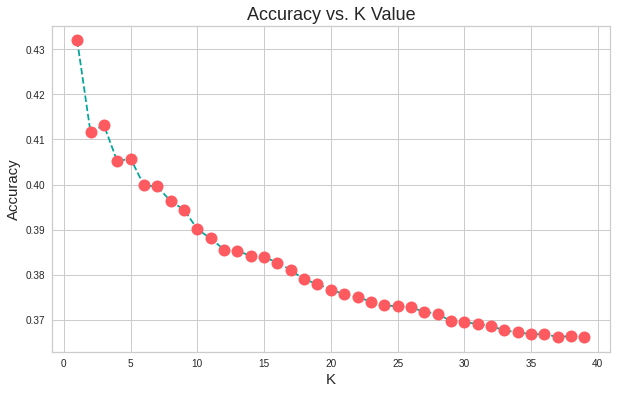

In [133]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40), acc, color = '#00A699', linestyle = 'dashed', 
         marker = 'o', markerfacecolor = '#FF5A5F', markersize = 12)
plt.title('Accuracy vs. K Value', fontsize = 18)
plt.xlabel('K', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
print("Maximum Accuracy:-", max(acc),"at K =", acc.index(max(acc)))

**Hyperparameter Tuning - RandomizedSearchCV**

In the hyperparameter tuning, instead of picking all models, we decide to perform the tuning for the logistic regresson model through a randomized search with cross-validation. Although SVC was the best performing model by virtue of the total number of performance metrics performing the best, it has efficiency issues. 

The primary aim was to improve the F1 macro score evaluation metric for logistic regression.

1. KneighborsClassifier: F1 score
2. AdaBoostClassifier
3. GradientBoostingClassifier

Multinomial - no hyperparameters to tune

**LogisticRegression**

In [134]:
model = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)

# Define search space
space = {"solver": ['lbfgs', 'liblinear'],
         "penalty": ['none', 'l1', 'l2', 'elasticnet'],
         "C": [0.001, 0.01, 0.1, 1, 10],
         "multi_class": ['auto', 'ovr']}

# Create an instance for RandomizedSearchCV Cross-validation estimator
search = RandomizedSearchCV(model, space, 
                            n_iter = 100, 
                            scoring = 'f1_macro', 
                            random_state = RANDOM_SEED)

# Execute search
result = search.fit(X_train, y_train)
result.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'multi_class': 'auto', 'C': 1}

In [135]:
X_test = vectorizer.transform(test_df.cleaned_comments)
y_test = list(test_df.sentiment)

model_default = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED).fit(X_train, y_train)
model_tuned = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', multi_class = 'auto', random_state = RANDOM_SEED).fit(X_train, y_train)
evaluation_models = [model_default, model_tuned]

accuracy = []
precision = []
recall = []
f1score = []
jaccard = []
fbeta = []
roc_auc = []
logloss_ = []

for model in evaluation_models:
  model_predict = model.predict(vectorizer.transform(test_df.cleaned_comments))
  accuracy.append(accuracy_score(model_predict, y_test))
  precision.append(precision_score(model_predict, y_test, average = 'macro'))
  recall.append(recall_score(model_predict, y_test, average = 'macro'))
  f1score.append(f1_score(model_predict, y_test, average = 'macro'))
  jaccard.append(jaccard_score(model_predict, y_test, average = 'macro'))
  fbeta.append(fbeta_score(model_predict, y_test, average = 'macro', beta = 0.5))
  roc_auc.append(roc_auc_score(y_test, model.predict_proba(vectorizer.transform(test_df.cleaned_comments)), multi_class = 'ovr', average = 'macro'))
  logloss_.append(log_loss(y_test, model.predict_proba(vectorizer.transform(test_df.cleaned_comments))))

model_names = ["LogisticRegression (Default)", "LogisticRegression (Tuned)"]
pd.DataFrame(list(zip(model_names, accuracy, precision, recall, f1score, jaccard, fbeta, roc_auc, logloss_)),
               columns =['Classifier', 'Accuracy (Balanced)', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)', 'Jaccard Score (Macro)', 'F-beta Score (Macro)', 'AUC ROC Score', 'Log Loss'])

,Classifier,Accuracy (Balanced),Precision (Macro),Recall (Macro),F1 Score (Macro),Jaccard Score (Macro),F-beta Score (Macro),AUC ROC Score,Log Loss
0,LogisticRegression (Default),0.912685,0.912117,0.912303,0.912186,0.839338,0.912139,0.978955,0.277033
1,LogisticRegression (Tuned),0.914951,0.914150,0.914344,0.914189,0.842871,0.914152,0.977672,0.285883


# **Evaluation**

**ROC-AUC Curve plots**

In [136]:
def plot_ROC_curve(model, X_train, y_train, X_val, y_val):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder = {'Positive': 'Positive', 
                                          'Neutral': 'Neutral', 
                                          'Negative': 'Negative'},
                        fig = plt.figure(figsize=(8,5)))
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_val, y_val)
    visualizer.show()
    
    return visualizer

  0%|          | 0/2 [00:00<?, ?it/s]

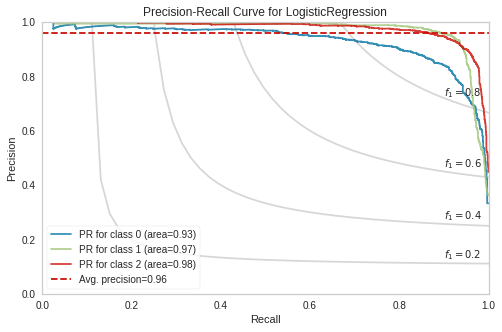

 50%|█████     | 1/2 [00:02<00:02,  2.43s/it]

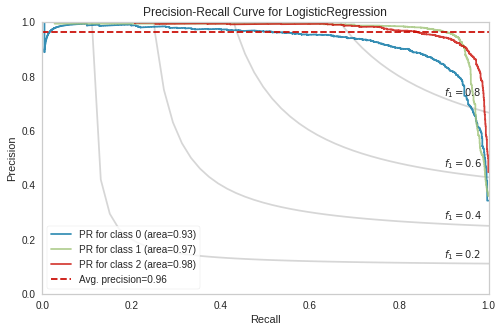

100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


In [137]:
for model in tqdm(evaluation_models):
  precision_recall_curve_plot(model, X_train, y_train, X_test, y_test)

**Precision-Recall Curve**

In [138]:
def precision_recall_curve_plot(model, X_train, y_train, X_val, y_val):
  visualizer = PrecisionRecallCurve(model, per_class = True, fill_area = False, iso_f1_curves = True, fig = plt.figure(figsize=(8,5)))
  visualizer.fit(X_train, y_train)
  visualizer.score(X_val, y_val)
  visualizer.show()
  return visualizer

  0%|          | 0/2 [00:00<?, ?it/s]

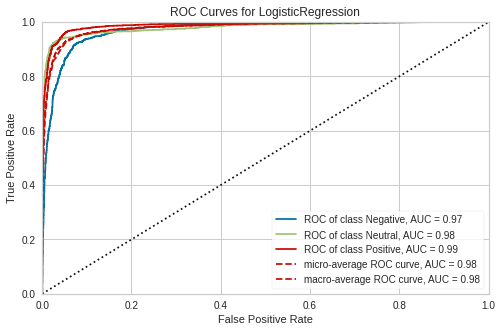

 50%|█████     | 1/2 [00:00<00:00,  3.44it/s]

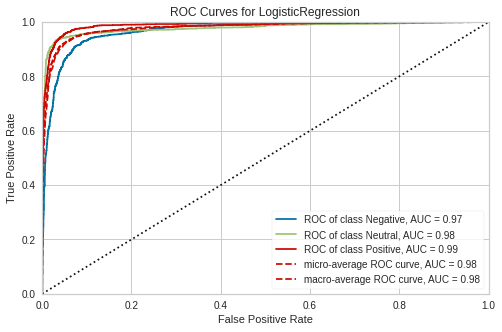

100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


In [139]:
for model in tqdm(evaluation_models):
  plot_ROC_curve(model, X_train, y_train, X_test, y_test)

#**Failure Analysis**

**Confusion Matrix Heatmap**

In [140]:
def plot_Confusion_Matrix_Heatmap(model, X_train, y_train, X_val, y_val):

    classes = ['Positive', 'Neutral', 'Negative']
    visualizer = ConfusionMatrix(
        model, classes = classes,
        percent = True,
        label_encoder = {'Positive': 'Positive', 
                         'Neutral': 'Neutral', 
                         'Negative': 'Negative'},
        fig = plt.figure(figsize=(8,5)))

    visualizer.fit(X_train, y_train)
    visualizer.score(X_val, y_val)
    visualizer.show()
    
    return visualizer

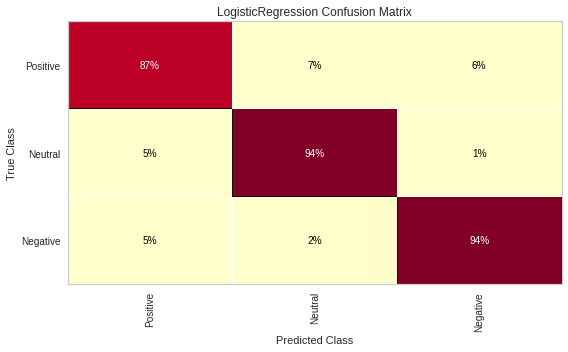

ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f38f42806d0>,
                classes=['Positive', 'Neutral', 'Negative'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7f38f5728d10>,
                estimator=LogisticRegression(C=1, penalty='l1', random_state=42,
                                             solver='liblinear'),
                percent=True)

In [141]:
plot_Confusion_Matrix_Heatmap(LogisticRegression(C=1, penalty='l1', random_state = RANDOM_SEED, solver='liblinear'), X_train, y_train, X_test, y_test)

**Classification Report**

In [142]:
target_names = ['Positive', 'Neutral', 'Negative']

model_tuned = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', multi_class = 'auto', random_state = RANDOM_SEED).fit(X_train, y_train)
model_predict = model.predict(X_test)
print(classification_report(y_test, model_predict, target_names = target_names))

              precision    recall  f1-score   support

    Positive       0.89      0.87      0.88      1561
     Neutral       0.92      0.94      0.93      1685
    Negative       0.93      0.94      0.93      1610

    accuracy                           0.91      4856
   macro avg       0.91      0.91      0.91      4856
weighted avg       0.91      0.91      0.91      4856

